Pour info voici mon pipeline de preprocessing. VU que je travaille sur mon laptop j'ai pas énormément de RAM (8g + 8g de swap) donc je suis obligé de découper un peu le travail mais ça permet d'avoir une certaine trace dans les pré-traitements/


In [1]:
name_subj = "S12"

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget

# Reading raw BDF, setting up bipolar references and montage

In [2]:
raw = mne.io.read_raw_bdf('../../raw_data/%s.bdf'%name_subj,preload=True, verbose=True)

Extracting EDF parameters from /home/gweindel/ownCloud/PhD/Projets/ForceEEG/raw_data/S12.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5602303  =      0.000 ...  5470.999 secs...


In [3]:
mne.set_bipolar_reference(raw,anode=['EXG1','EXG3','EXG5','EXG7'],cathode=['EXG2','EXG4','EXG6','Fp2'],ch_name=['EMG_L','EMG_R','EOGH','EOGV'],copy=False, drop_refs=False) #fixe les références bipolaires pour les électrodes externes
raw.set_channel_types({'EMG_L':'emg','EMG_R':'emg','EOGH':'eog','EOGV':'eog','EXG8':'misc','Erg1':'misc','Erg2':'misc'}) #Détermine les types de canaux 
raw.set_eeg_reference(['EXG8']) #référence eeg  mastoide gauche
raw.drop_channels(['EXG1','EXG3','EXG5','EXG7','EXG2','EXG4','EXG6'])

Bipolar channel added as "EMG_L".
Bipolar channel added as "EMG_R".
Bipolar channel added as "EOGH".
Bipolar channel added as "EOGV".
EEG channel type selected for re-referencing
Applying a custom EEG reference.


<RawEDF | S12.bdf, 72 x 5602304 (5471.0 s), ~3.01 GB, data loaded>

## Montage

Here I recover the measurment made using ElGuide, however I only use one file (.sfp) from the three generated by subject, but it seems to be OK. (BORIS ?)

In [4]:
EEGhead_pos = pd.read_csv('../../raw_data/data_ForceEEG_Montage/%s_Force_EEG.sfp'%name_subj,skiprows=3, sep="\t", index_col=0,header=None,usecols=[0,3,5,7])/1000 #mm scale
ref_pos = pd.read_csv('../../raw_data/data_ForceEEG_Montage/%s_Force_EEG.sfp'%name_subj,skiprows=0, sep="\t", index_col=0,header=None,usecols=[0,3,6,9],nrows=3)/1000 #mm scale

EEGhead_pos = EEGhead_pos[(np.abs(EEGhead_pos[3]) < (np.std(EEGhead_pos[3])*8))]#removes weird postiion samples larger than 8sd

EEGkeys = EEGhead_pos[:64].index
EEGvalues = np.asarray(EEGhead_pos[:64].reset_index(drop=True))
EEG_points = dict(zip(EEGkeys, EEGvalues))

left, nasion, right = ref_pos.loc["fidt9"].values,ref_pos.loc["fidnz"].values,ref_pos.loc["fidt10"].values #Check LR correctness
head_points = np.asarray(EEGhead_pos[64:].reset_index(drop=True))

dig_montage = mne.channels.make_dig_montage(ch_pos=EEG_points, nasion=nasion, lpa=left, rpa=right, 
                                            hsp=head_points, hpi=None, coord_frame='head')

### Plotting sensor locations

In [8]:
dig_montage.plot(kind='3d');


Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [6]:
raw.set_montage(dig_montage)
raw.plot_sensors(show_names=True);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Low-pass filtering

In [7]:
raw.filter(None, 100, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') #filtre les données entre 0.01 et 100 Hz


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 135 samples (0.132 sec)



<RawEDF | S12.bdf, 72 x 5602304 (5471.0 s), ~3.01 GB, data loaded>

## Checking for bad electrodes before applying average referencing

Here I take a first quick look at the data to detect really faulty or flat electrodes, plot not displayed in the notebook I send you because it is not very useful

In [12]:
raw.plot();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Notes : 
- PO7 captures continuous high frequency at half-way, as it is (relatively...) far from ROI I interpolate
- No Force for this participant

In [13]:
raw.info['bads']

['PO7']

I save the data, hence saving the montage, the low-pass filtered data, the annotation of the bad channel

Additionally I re-reference to average as EXG8 is particularly noisy making artifact detection difficult. Plus, simulation studies show that ICA is best achieved using average reference rather than _linked_ mastoids [référence](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6798171/). BTW marking channels as bad before referencing to the average is sufficient to exclude them from the computation of the average

In [14]:
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<RawEDF | S12.bdf, 72 x 5602304 (5471.0 s), ~3.01 GB, data loaded>

In [16]:
raw.save("%s/pre_rejection_%s.fif"%(name_subj,name_subj),overwrite=True) #sauvegarde les données au format fif pour la suite des traitements

Writing /home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessing/S12/pre_rejection_S12.fif


<ipython-input-16-e39f8df35fab>:1: RuntimeWarning: This filename (/home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessing/S12/pre_rejection_S12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save("%s/pre_rejection_%s.fif"%(name_subj,name_subj),overwrite=True) #sauvegarde les données au format fif pour la suite des traitements


Closing /home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessing/S12/pre_rejection_S12.fif [done]


# Rejecting artefacts

## For the remaining sections and up to the ICA reconstruction I only work with 1Hz High pass filtered data 

The reason being that annotation marked as bad, if not previously filtered to remove slow drifts, gives crazy ICA results (probably because it then captures a lot of edge artifacts from the drifts occuring between the breaks), plus lightly filtered data and average reference seems to ease the detection of artifact, both visually and with the ICA. But the final data (after reconstruction) will remain filtered at 0.01Hz as we usually do and as is recommended for ERP analysis

In [ ]:
raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)

In [17]:
filt_raw = raw.copy().load_data().filter(l_freq=1., h_freq=None) # I filter to ease processing (and problem with BAD_breaks)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3379 samples (3.300 sec)



### Recovering events

Code to recover EMG markers and to merge force condition trigger and stim trigger (had to send them separately because of the number of bits and the coding scheme).

In [18]:
original_evts = pd.read_csv('../../processing_EMG/processed/corrected/%s_corrected_evts.csv'%name_subj)
original_evts.code = [int(x) for x in original_evts.code]
original_evts.chan = [int(x) for x in original_evts.chan]
del original_evts["time"]
resp_id = [200, 100]
stim_id = [111,112,113,121,122,123,211,212,213,221,222,223]
force_id = [1,2]
combined_id = [int(str(x[1]) + str(x[0]))  for x in zip(np.tile(stim_id,2), np.repeat(force_id,len(stim_id)))]

emg_chan = [0,1]


evts = original_evts.values

i = 0
max_trials = np.sum(np.isin(evts[:,1], stim_id))
while i < len(evts)-1:
    while evts[i,1] not in force_id and i < len(evts)-1:
        i += 1
    force_trigger = i
    while evts[i,1] not in stim_id and i < len(evts)-1:
        i += 1
    stim_trigger = i
    if i < len(evts)-1:
        evts[stim_trigger, 1] = int(str(evts[force_trigger, 1]) + str(evts[stim_trigger, 1]))
    i += 1
print(np.sum(np.isin(evts[:,1], stim_id)) == 0)
print(np.sum(np.isin(evts[:,1], combined_id)) == max_trials)
original_evts = original_evts.drop(original_evts.iloc[np.isin(evts[:,1], force_id)].index)

True
True


Saving the extracted events

In [19]:
original_evts.to_csv('%s/events_%s.csv'%(name_subj, name_subj))

Total of trials used in the following code

In [20]:
np.sum(np.isin(original_evts.code.values, combined_id))

2448

Correcting the event file to adapt to MNEs events format and keeping only stimuls and response events

In [21]:
evts = original_evts.values
stim_rep_evts = evts[np.isin(evts[:,1], combined_id) | np.isin(evts[:,1], resp_id) ]
stim_rep_evts[:,2] = stim_rep_evts[:,1]

__FYI__ : visualisation of the course of the trials (y= trigger, x=recorded sample) during the experiment for the subject: 

_stimulus trigger_ = XXXX = Force (1:low, 2:High), SAT (1:Accuracy, 2:Speed), expected response (1:left, 2:Right), contrast (1 - 3)

_response trigger_ = 100 (left) 200 (right)

In [22]:
mne.viz.plot_events(stim_rep_evts);

<ipython-input-22-b319de41a708>:1: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(stim_rep_evts);


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Detecting and annotating breaks

In the two following cells I mark the period of breaks between the block. I do it because we cannot use these periods in the ICA because they are highly noisy, hence I annotate them and exclude them from the following ICA analysis. I define a break as a duration of more than 10 sec between a response and a stimulus trigger (the duration might be different for other subjects but 10 seconds catches the number of expected breaks)

In [43]:
onset_breaks = stim_rep_evts[np.where(np.diff(stim_rep_evts[:,0], n=1) > (1024*10))][:,0]/1024 #detecting latencies between triggers > 5 sec (searching for the 23 self-paced breaks, and the start of the recording)
offset_breaks = np.flip(np.flip(stim_rep_evts)[np.where(np.diff(np.flip(stim_rep_evts[:,0]), n=1) < -(1024*10))])[:,0]/1024

onset_breaks = onset_breaks + 1 #add 1 sec after last response trigger
offset_breaks = offset_breaks - 1 #removes 1 sec before next stimulus trigger

onset_breaks = np.insert(onset_breaks,0,0)#just adding start of the recording to the breaks
onset_breaks = np.insert(onset_breaks,-1, stim_rep_evts[-1,0]/1024+1)#just adding end of the recording to the breaks

offset_breaks = np.insert(offset_breaks,0,stim_rep_evts[0,0]/1024-1)#just adding start of the recording to the breaks
offset_breaks = np.insert(offset_breaks,-1, raw.times.max())#just adding end of the recording to the breaks



duration_breaks = np.asarray(offset_breaks) - np.asarray(onset_breaks)


print(len(duration_breaks))

25


25 breaks = 23 self paced breaks + beginning of recording + end of recording

In [44]:
#Note I have to add a dummy "BAD_" marker in order to use this category in the visual window (because I'm using plt widget)
break_annot = mne.Annotations(onset= np.insert(onset_breaks, len(onset_breaks), 0),
                           duration= np.insert(duration_breaks, len(onset_breaks), 1),
                           description=np.insert(np.repeat(['BAD_breaks'], len(onset_breaks)),len(onset_breaks), 'BAD_'))
filt_raw.set_annotations(break_annot)

<RawEDF | S12.bdf, 72 x 5602304 (5471.0 s), ~3.01 GB, data loaded>

## visual artifact rejection

event trigger color code

In [45]:
color_dict = {k:'b' for k in combined_id}
color_dict.update({100:'r', 200:'r'})

Channel order (as we are mainly interesetd with visual latencies I plot the channels from posterior to anterior)

In [46]:
channels = dict(zip(raw.ch_names, np.arange(len(raw.ch_names))))

ch_order= [70,71, 27,63,28,26,61,62,29,24,25,60,59,58,57,56,30,19,20,21,22,23,\
           52,53,54,55,31,18,17,16,15,51,50,49,48,47,11,12,13,14,42,43,44,45,46,\
           10,9,8,7,41,40,39,38,37,3,4,5,6,34,35,36,2,1,33,32,0]


### Visualisation window

Brief summary of my artifact rejection philosophy : - 
- Rejecting very rare artifacts present on ROI (mainly visual and motor cortices) in the timing of interest (a bit before stim to a bit after rep)
- I mark when blinks/saccades are during stim presentation as information is delayed/biased (I therefore also display EOG)
- Rejecting rare high variance artifacts (e.g. EMG on all channels) to avoid that these obvious artifact be picked by the ICA
- Keeping recurrent artifacts likely to get picked up by artifact 

So in few words : avoid biasing ERPs and ease the following ICA, mark as less as possible because I want to reject epochs with ICA survival artifacts after all the preprocessing

In [47]:
filt_raw.plot(events=stim_rep_evts, event_color=color_dict, remove_dc=True, order=ch_order, title="Artifact rejection window");

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Notes based on raw inspection : 
- Artifact on occipital electrodes synchroneous to the response by the subject (and present in all electrodes), at the bginning and in high force at least (appears to be true only for the two first blocks)
- Occipital electrodes captures some high frequencies, should be filtered, FC2, CP5, CZ , F7 and pre-frontal electrodes also picks it up
- lots and lots of alpha beginning block 4
- FT7 jumps

Number of annotation + saving

In [50]:
filt_raw.annotations

<Annotations | 54 segments: BAD_ (29), BAD_breaks (25)>

In [51]:
filt_raw.annotations.save('%s/saved_annotations_%s.csv'%(name_subj,name_subj))
#annot_from_file = mne.read_annotations('saved-annotations.csv')
#print(annot_from_file)

Saving the (high-pass filtered) data with the annotations for breaks and artifact

In [52]:
filt_raw.save("%s/pre_ica_%s.fif"%(name_subj,name_subj),overwrite=True)

Writing /home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessing/S12/pre_ica_S12.fif


<ipython-input-52-b5f5a09c0b2f>:1: RuntimeWarning: This filename (/home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessing/S12/pre_ica_S12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw.save("%s/pre_ica_%s.fif"%(name_subj,name_subj),overwrite=True)


Closing /home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessing/S12/pre_ica_S12.fif [done]


# Fitting ICA

In [2]:
filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)

Opening raw data file S12/pre_ica_S12.fif...


<ipython-input-2-a412b60167ca>:1: RuntimeWarning: This filename (S12/pre_ica_S12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)


    Range : 0 ... 5602303 =      0.000 ...  5470.999 secs
Ready.
Reading 0 ... 5602303  =      0.000 ...  5470.999 secs...


In [3]:
ica = mne.preprocessing.ICA(max_pca_components = 64-len(filt_raw.info["bads"])-1) #-1 because better when average reference is used (rank)
ica.fit(filt_raw.crop(tmax=filt_raw.times.max()), reject_by_annotation=True, decim=2)
        #I use decim=2 to downsample to 512Hz because ICA eats up a lot of RAM For this subjct I also crop the 1000 last seconds for that reason

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Omitting 1271083 of 5602304 (22.69%) samples, retaining 4331221 (77.31%) samples.
Selecting all PCA components: 62 components
Fitting ICA took 455.8s.


<ICA  |  raw data decomposition, fit (fastica): 2165611 samples, 62 components, channels used: "eeg">

In [4]:
ica.save("%s/ICA_object_%s.fif"%(name_subj,name_subj))

Writing ICA solution to S12/ICA_object_S12.fif...


<ipython-input-4-999a4b462724>:1: RuntimeWarning: This filename (S12/ICA_object_S12.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save("%s/ICA_object_%s.fif"%(name_subj,name_subj))


<ICA  |  raw data decomposition, fit (fastica): 2165611 samples, 62 components, channels used: "eeg">

# Inspecting ICA

__Nota Bene__ : I fitted the ICA on the filtered continuous data, however I want to know how the ICA cleaned the epoched data, hence I inspect the ICA components mainly on the epoched data from the raw data (no low-pass filter other than the one used by biosemi, 0.01 Hz right ?)

In [5]:
raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)

Opening raw data file S12/pre_rejection_S12.fif...


<ipython-input-5-51b23dce2bfc>:1: RuntimeWarning: This filename (S12/pre_rejection_S12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("%s/pre_rejection_%s.fif"%(name_subj,name_subj), preload=False)


    Range : 0 ... 5602303 =      0.000 ...  5470.999 secs
Ready.


In [6]:
annot_from_file = mne.read_annotations('%s/saved_annotations_%s.csv'%(name_subj,name_subj))
raw.set_annotations(annot_from_file)
print(raw.annotations)

<Annotations | 54 segments: BAD_ (29), BAD_breaks (25)>


In [7]:
ica = mne.preprocessing.read_ica("%s/ICA_object_%s.fif"%(name_subj,name_subj))

Reading S12/ICA_object_S12.fif ...
Now restoring ICA solution ...
Ready.


<ipython-input-7-c4cd4f34906e>:1: RuntimeWarning: This filename (S12/ICA_object_S12.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica = mne.preprocessing.read_ica("%s/ICA_object_%s.fif"%(name_subj,name_subj))


### Visualizing on epochs

In [8]:
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/speed/accuracy/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/speed/accuracy/3':2223,} # used for segmentation

original_evts = pd.read_csv('%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.values
evts[:,2] = evts[:,1]

epochs_ica = mne.Epochs(raw, evts, event_id=trig_id, tmin=-0.5, tmax=1, preload=True)

2448 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2448 events and 1537 original time points ...
33 bad epochs dropped


In [9]:
epochs_ica.resample(500)

<Epochs  |   2415 events (all good), -0.5 - 0.998 sec, baseline [None, 0], ~995.5 MB, data loaded,
 'high/accuracy/left/1': 98
 'high/accuracy/left/2': 101
 'high/accuracy/left/3': 102
 'high/accuracy/right/1': 102
 'high/accuracy/right/2': 101
 'high/speed/accuracy/3': 102
 'high/speed/left/1': 100
 'high/speed/left/2': 101
 'high/speed/left/3': 101
 'high/speed/right/1': 100
 'high/speed/right/2': 99
 'high/speed/right/3': 99
 'low/accuracy/left/1': 101
 'low/accuracy/left/2': 100
 'low/accuracy/left/3': 101
 'low/accuracy/right/1': 102
 'low/accuracy/right/2': 102
 'low/speed/accuracy/3': 98
 'low/speed/left/1': 102
 'low/speed/left/2': 100
 'low/speed/left/3': 102
 'low/speed/right/1': 100
 'low/speed/right/2': 100
 'low/speed/right/3': 101>

### ICs epoch timecourse


In [10]:
ica.plot_sources(epochs_ica);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

__Nota Bene__ : epochs are dropped if artifact is in the epoch window

Notes from epoch time course of the ICs : 
- Eyes : 14, 22, 28, 30
- EMG : 14, 15, 17, 32, 42,43, 46, 48, 50, 57
- Suspicous : 8,10,27,29,32,35,36,46,47,51,60

### ICs topomap

In [11]:
ica.plot_components();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Notes from epoch time course of the ICs : 
- Eyes : 14, 22, 28, 30
- EMG : 14, 15, 17, 32, 42,43, 46, 48, 50, 57
- Suspicous : 8,10,27,29,32,35,36,46,47,51,60

Notes on ICs based on topomap  : 
- Blinks : 30
- Suspicious : 35,51
- saccades/face EMG : 8,10,14,29,32,33,36,42,43,47,48,57,60
- TP EMG :  3,4,7,15,17,25,27,28,44,46,50
- channel noise : 13,19,38,49


In [12]:
comp_to_inspect = np.array([14, 22, 28, 30,14, 15, 17, 32, 42,43, 46, 48, 50, 57,8,10,27,29,32,35,36,46,47,51,60,30,35,51, 8,10,14,29,32,33,36,42,43,47,48,57,60,3,4,7,15,17,25,27,28,44,46,50,13,19,38,49])
comp_to_inspect = np.sort(np.unique(comp_to_inspect))
print(comp_to_inspect)

[ 3  4  7  8 10 13 14 15 17 19 22 25 27 28 29 30 32 33 35 36 38 42 43 44
 46 47 48 49 50 51 57 60]


## Individual ICs inspection

During the next lines I inspect each EOG, EMG or suspicious IC and decide, after the plots of each category, wether to KEEP or to REJECT the IC

### EOG : Checking against recorded EOG (horizontal and vertical)

This section looks at the covariation between the recorded EOG (horizontal and vertical) and the extracted ICs to find those ICs that likely contains eyes artifacts

In [13]:
filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)

eog_indices, eog_scores = ica.find_bads_eog(filt_raw.resample(500))
ica.exclude = eog_indices

Opening raw data file S12/pre_ica_S12.fif...


<ipython-input-13-af9efacd6f55>:1: RuntimeWarning: This filename (S12/pre_ica_S12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  filt_raw = mne.io.read_raw_fif("%s/pre_ica_%s.fif"%(name_subj,name_subj), preload=True)


    Range : 0 ... 5602303 =      0.000 ...  5470.999 secs
Ready.
Reading 0 ... 5602303  =      0.000 ...  5470.999 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7344 events found
Event IDs: [  1   2 100 111 112 113 121 122 123 200 211 212 213 221 222 223]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
7344 events found
Event IDs: [  1   2 100 111 112 113 121 122 123 200 211 212 213 221 222 223]
Omitting 620645 of 2735500 (22.69%) samples, retaining 2114855 (77.31%) samples.
Omitting 620645 of 2735500 (22.69%) samples, retaining 2114855 (77.31%) samples.
Omitting 620645 of 2735500 (22.69%) samples, retaining 2114855 (77.31%) samples.
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
--------------------

Now I plot the scores, namely the "covariance" between HEOG (top panel), VEOG (lower panel) and the ICs (x axis)

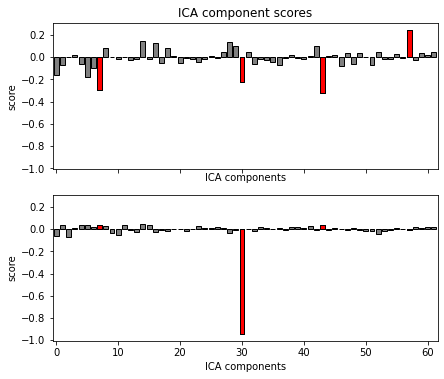

In [14]:
ica.plot_scores(eog_scores);

MNE's algorithm extracted automatically the following ICs :

In [15]:
eog_indices

[30, 43, 7, 57]

Now I plot for each of these components the topomap; the activity for the created epochs around the stimulus (presentation of the stimuls at 0.2 sec); the spectrum, and the variance of the IC measured at each epoch (watch out the y-axis of this last plot varies a lot across ICs)

In [16]:
inspected_comp = np.array([30, 43, 7, 57])

    Using multitaper spectrum estimation with 7 DPSS windows
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


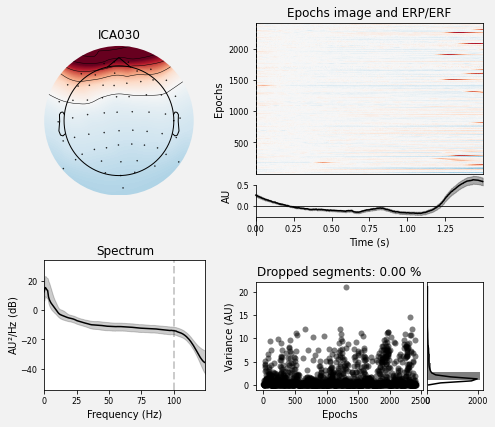

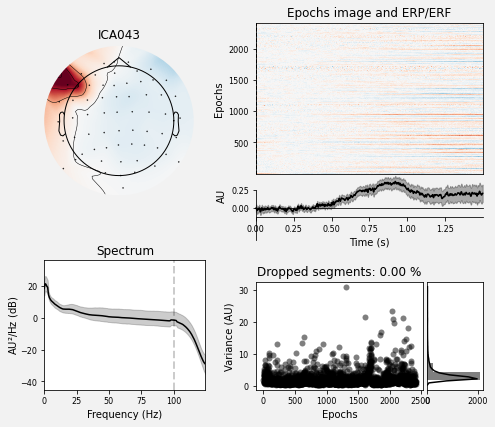

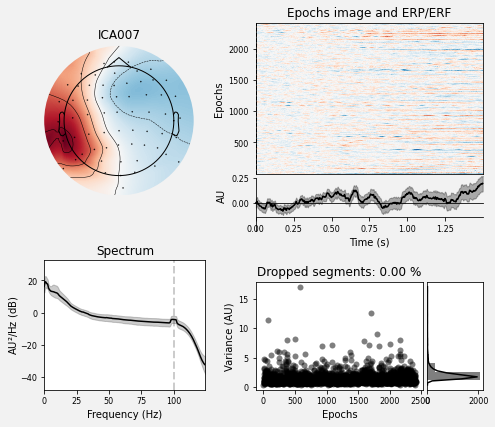

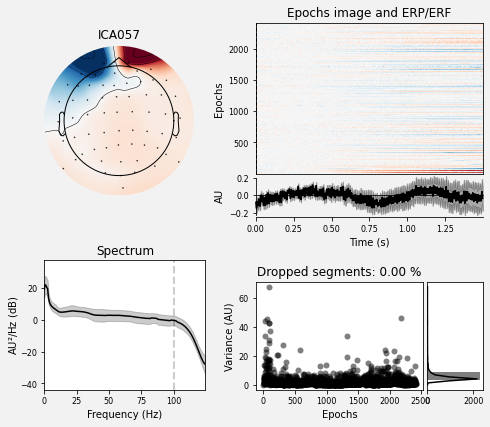

In [17]:
ica.plot_properties(epochs_ica, picks=inspected_comp);

#### Interpretation of the EOG ICs
- ICA 30 contains blinks REJECT
- 43,57 = Saccades REJECT
- 7, unclear KEEP


In [18]:
ica.exclude = []
eog_comp = [30,43,57]
comp_to_inspect = comp_to_inspect[np.isin(comp_to_inspect, inspected_comp, invert=True)]

### EMG components

#### Suspected EMG activity from the face

from the notes above the general plot of the ICs (time course and topomap) I look at 8,10,14,29,32,33,36,42,47,48,60

In [19]:
inspected_comp = np.array([8,10,14,29,32,33,36,42,47,48,60])

    Using multitaper spectrum estimation with 7 DPSS windows
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseli

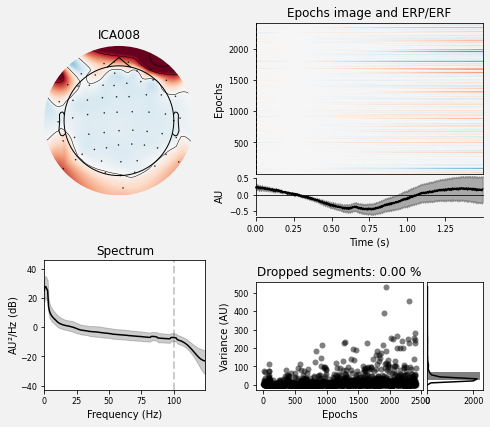

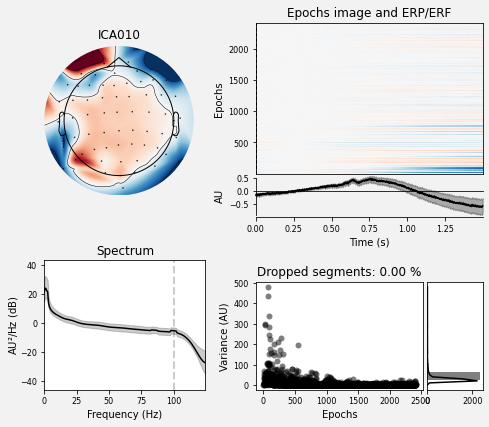

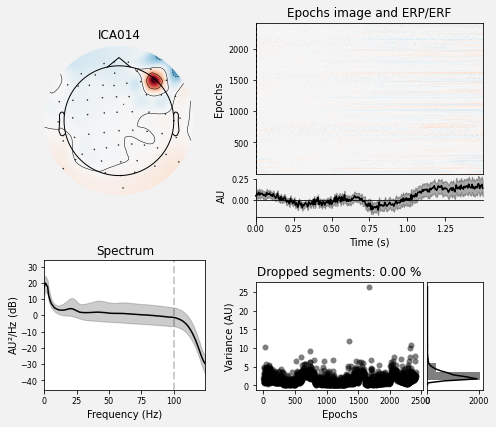

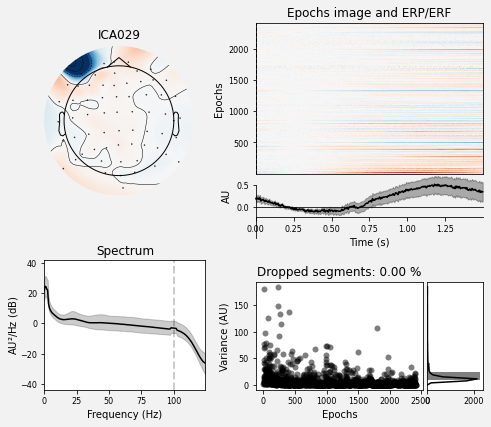

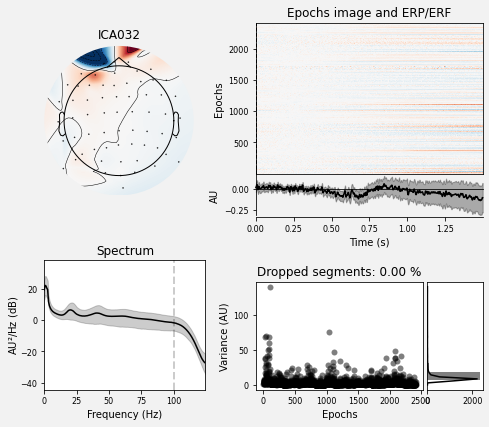

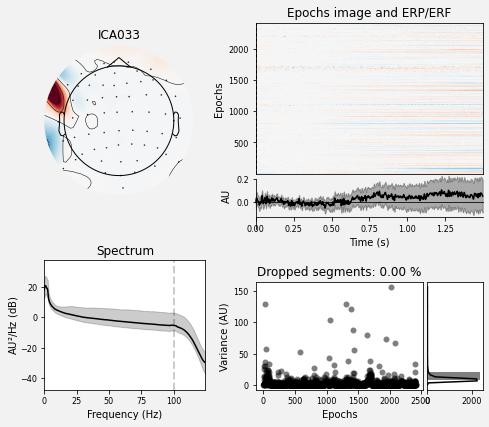

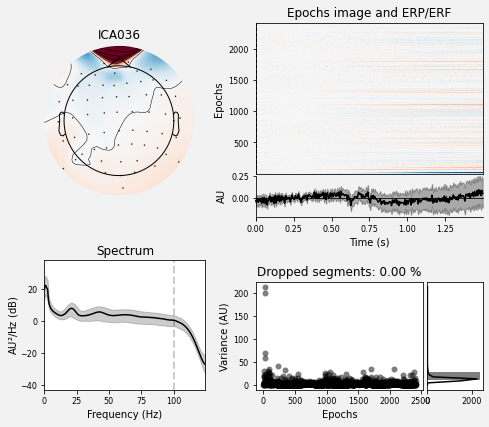

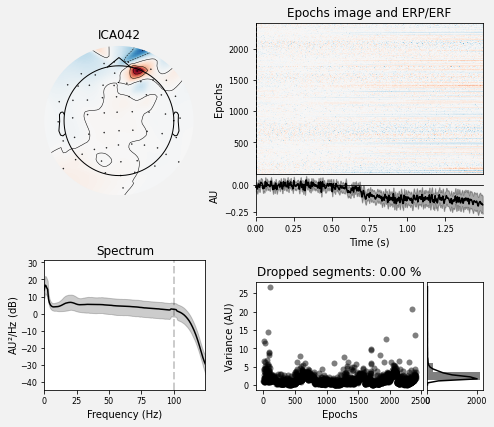

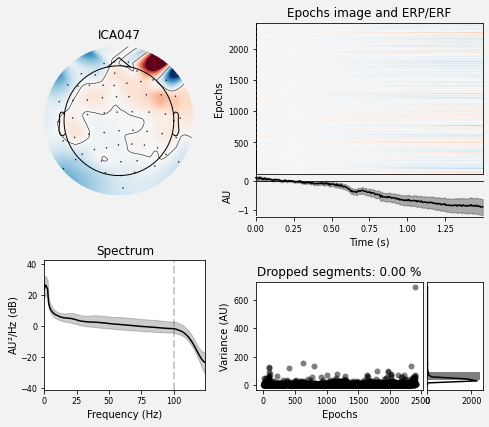

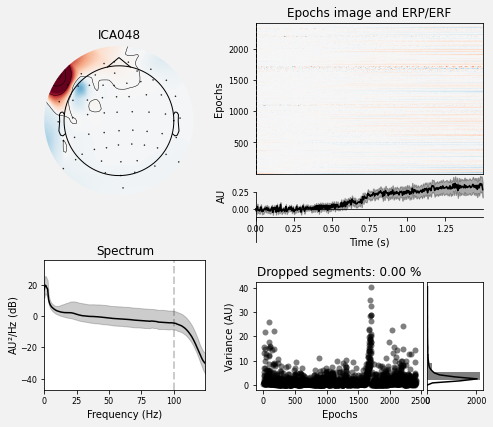

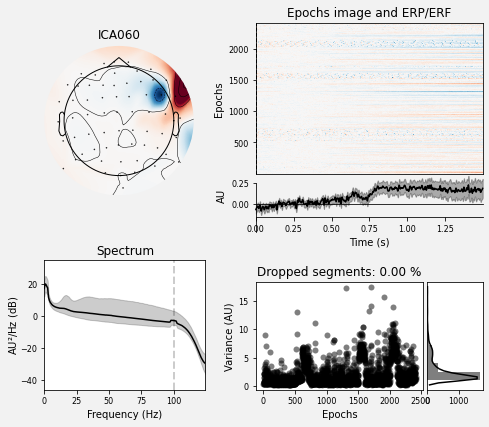

In [20]:
ica.plot_properties(epochs_ica, picks=inspected_comp);

- ICA 8,29,32,36,47 Face topo and huge variance, REJECT
- ICA 10,33 external topo far from ROI, mainly face, huge variance, REJECT
- 14,60, no reason, KEEP
- 42,48 EMG but not enough evidence, KEEP


In [21]:
face_emg_comp = [8,29,32,36,47,10,33]
comp_to_inspect = comp_to_inspect[np.isin(comp_to_inspect, inspected_comp, invert=True)]

#### Other suspected EMGs

In [22]:
inspected_comp = np.array([3,4,7,15,17,25,27,28,44,46,50])

    Using multitaper spectrum estimation with 7 DPSS windows
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseli

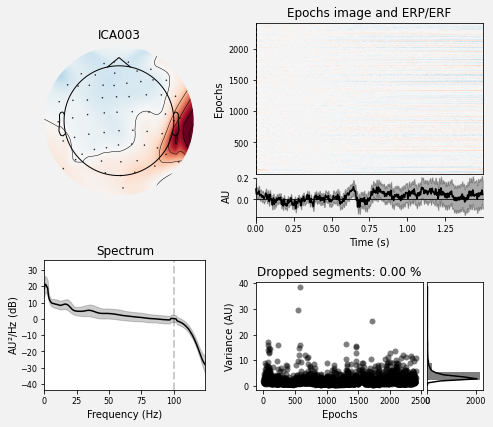

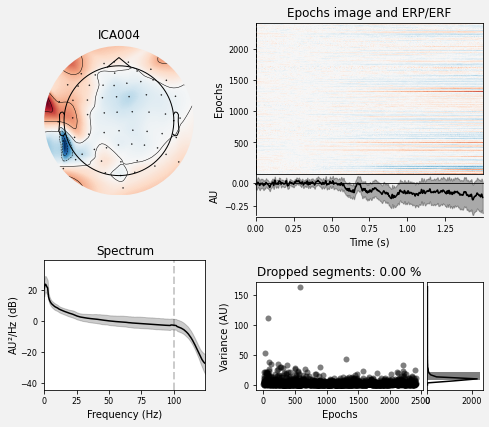

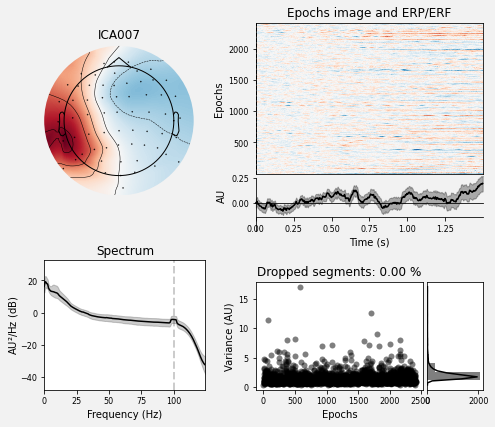

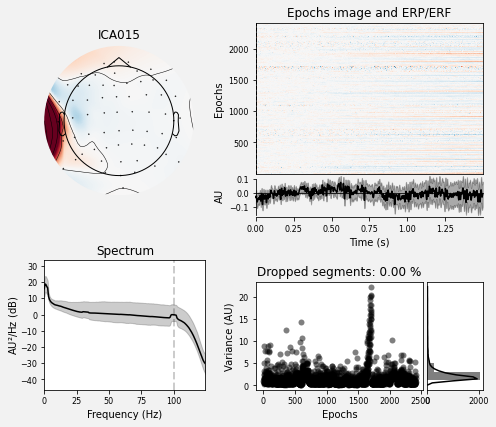

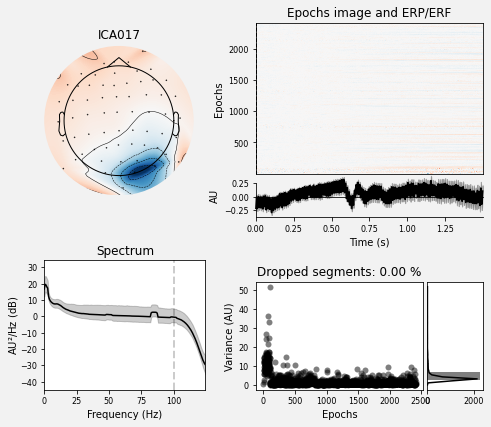

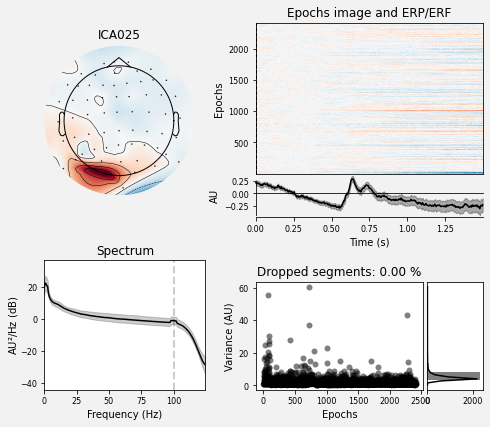

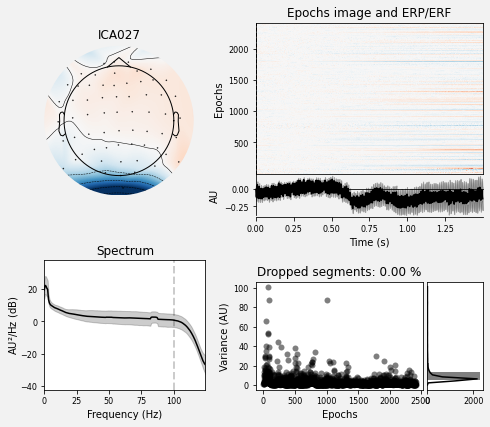

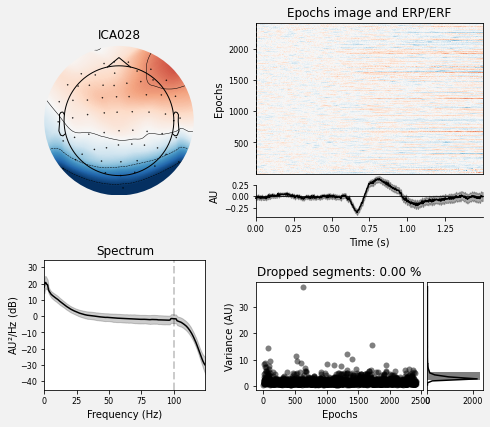

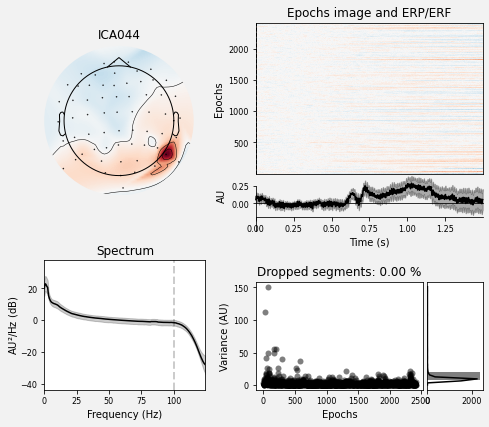

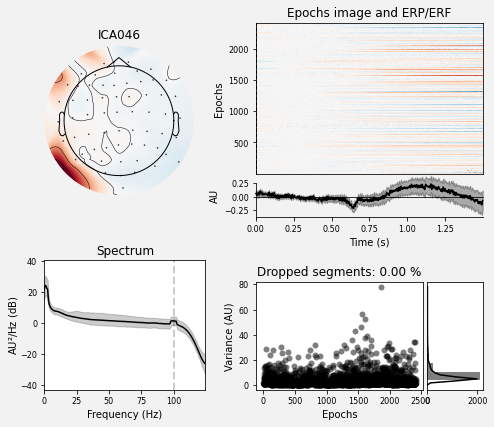

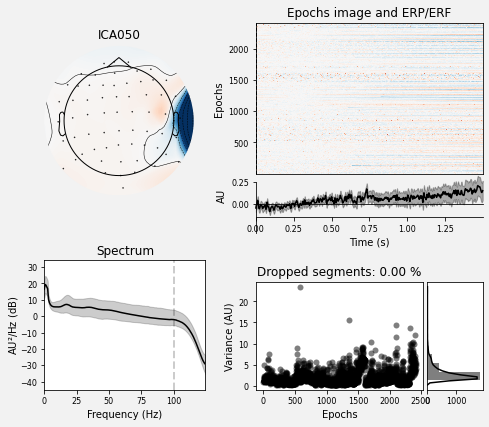

In [23]:
ica.plot_properties(epochs_ica, picks=inspected_comp);

- ICA 3,50 : TP EMG REJECT
- 4,7,25,28, 44,46 no reason KEEP
- 15 : TP topo, unclear spectrum, only high in few epochs KEEP
- 17,27 : 80 Hz artifact detected at raw viz, should probably be filtered KEEP


In [24]:
other_emg_comp = [3,50]
comp_to_inspect = comp_to_inspect[np.isin(comp_to_inspect, inspected_comp, invert=True)]

## Other strange components

In [25]:
print(comp_to_inspect)

[13 19 22 35 38 49 51]


    Using multitaper spectrum estimation with 7 DPSS windows
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
2415 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


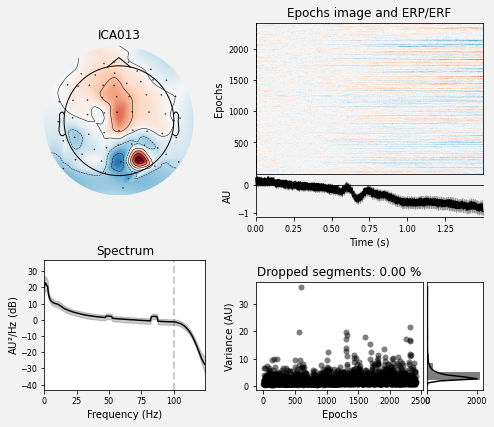

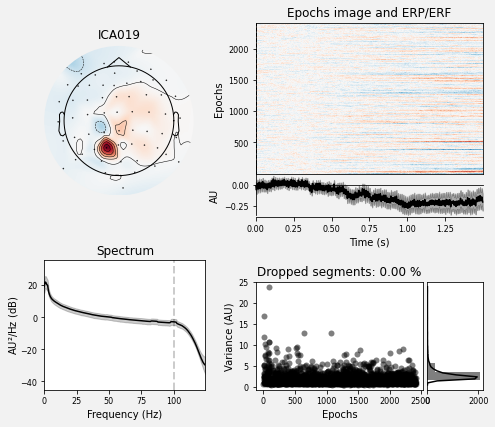

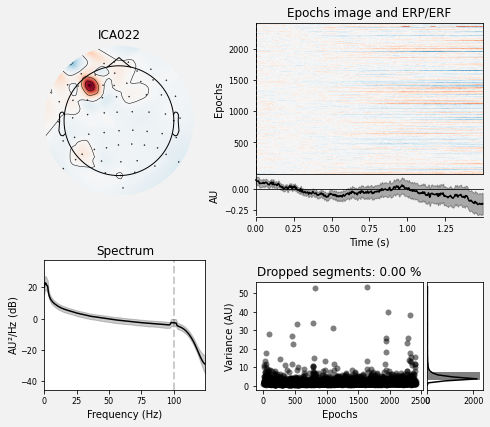

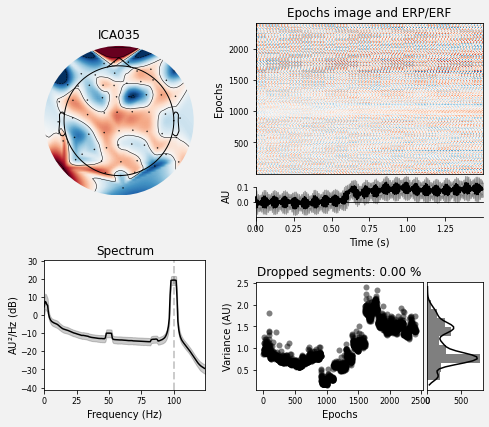

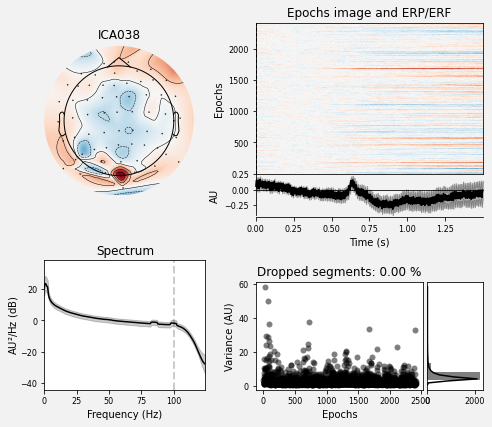

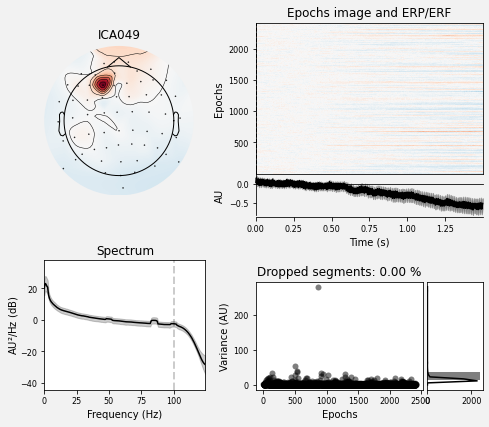

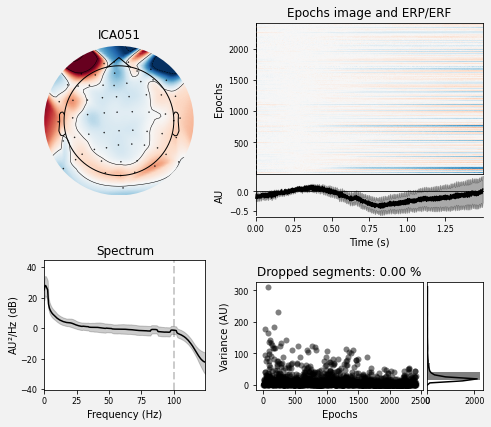

In [26]:
ica.plot_properties(epochs_ica, picks=comp_to_inspect);

- ICA 13 : peak at 50 and 80Hz in ROI KEEP
- 19,22,38 : no reason KEEP
- 49, only problematic in one epoch, KEEP
- 51 artifact with huge variance, far from ROI, REJECT

In [27]:
other_comp = [51]

## Final exclusions of ICA components :

In [28]:
ica.exclude = eog_comp + face_emg_comp + other_emg_comp + other_comp 
print(ica.exclude)

[30, 43, 57, 8, 29, 32, 36, 47, 10, 33, 3, 50, 51]


In [29]:
ica.apply(raw.load_data())


Reading 0 ... 5602303  =      0.000 ...  5470.999 secs...
Transforming to ICA space (62 components)
Zeroing out 13 ICA components


<Raw | pre_rejection_S12.fif, 72 x 5602304 (5471.0 s), ~3.01 GB, data loaded>

## Interpolating the bad electrodes after ICA

In [30]:
raw.info['bads']

['PO7']

In [31]:
raw = raw.interpolate_bads()

    Automatic origin fit: head of radius 95.3 mm
Computing interpolation matrix from 63 sensor positions
Interpolating 1 sensors


In [32]:
raw.info['bads']

[]

# Saving the final preprocessed data

In [33]:
raw.save("../preprocessed_data/preprocessed_%s.fif"%name_subj,overwrite=True) #sauvegarde les données au format fif pour la suite des traitements

Writing /home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S12.fif


<ipython-input-33-02d1e10f2bb7>:1: RuntimeWarning: This filename (/home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S12.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw.save("../preprocessed_data/preprocessed_%s.fif"%name_subj,overwrite=True) #sauvegarde les données au format fif pour la suite des traitements


Closing /home/gweindel/ownCloud/PhD/Projets/ForceEEG/processing_EEG/preprocessed_data/preprocessed_S12.fif [done]


# Annexe 1: Comparing before/after ICA

Just for illustration puprose I plot the data on the epoch domain befaore and after ICA.

In [34]:
ica.exclude = [30, 43, 57, 8, 29, 32, 36, 47, 10, 33, 3, 50, 51]

epochs_pre_ica = epochs_ica.copy()
ica.apply(epochs_ica)

Transforming to ICA space (62 components)
Zeroing out 13 ICA components


<Epochs  |   2415 events (all good), -0.5 - 0.998 sec, baseline [None, 0], ~995.5 MB, data loaded,
 'high/accuracy/left/1': 98
 'high/accuracy/left/2': 101
 'high/accuracy/left/3': 102
 'high/accuracy/right/1': 102
 'high/accuracy/right/2': 101
 'high/speed/accuracy/3': 102
 'high/speed/left/1': 100
 'high/speed/left/2': 101
 'high/speed/left/3': 101
 'high/speed/right/1': 100
 'high/speed/right/2': 99
 'high/speed/right/3': 99
 'low/accuracy/left/1': 101
 'low/accuracy/left/2': 100
 'low/accuracy/left/3': 101
 'low/accuracy/right/1': 102
 'low/accuracy/right/2': 102
 'low/speed/accuracy/3': 98
 'low/speed/left/1': 102
 'low/speed/left/2': 100
 'low/speed/left/3': 102
 'low/speed/right/1': 100
 'low/speed/right/2': 100
 'low/speed/right/3': 101>

In [36]:
%matplotlib widget
epochs_pre_ica.plot(n_epochs=20,scalings = dict(eeg=60e-6), title="Without ICA");
epochs_ica.plot(n_epochs=20,scalings = dict(eeg=60e-6), title="With ICA");

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Annexe 2: Taking a look at the ERP in monopolar

Again just for illustration purpose I plot the ERP in monopolar (average referenced and low-pass filtered at 30Hz to make pretty plots :-)

In [4]:
raw = mne.io.read_raw_fif("../preprocessed_data/preprocessed_%s.fif"%name_subj, preload=True)

Opening raw data file ../preprocessed_data/preprocessed_S11.fif...


<ipython-input-4-4592548a7bf9>:1: RuntimeWarning: This filename (../preprocessed_data/preprocessed_S11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  raw = mne.io.read_raw_fif("../preprocessed_data/preprocessed_%s.fif"%name_subj, preload=True)


    Range : 0 ... 5229567 =      0.000 ...  5106.999 secs
Ready.
Reading 0 ... 5229567  =      0.000 ...  5106.999 secs...


In [37]:
raw.filter(None, 30, None,l_trans_bandwidth='auto',filter_length='auto',phase='zero') 


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 451 samples (0.440 sec)



<Raw | pre_rejection_S12.fif, 72 x 5602304 (5471.0 s), ~3.01 GB, data loaded>

### Creating epochs

In [38]:
trig_id = {'low/speed/left/1':1111,'low/speed/left/2':1112,'low/speed/left/3':1113,
           'low/speed/right/1':1121,'low/speed/right/2':1122,'low/speed/right/3':1123,
           'low/accuracy/left/1':1211,'low/accuracy/left/2':1212,'low/accuracy/left/3':1213,
           'low/accuracy/right/1':1221,'low/accuracy/right/2':1222,'low/speed/accuracy/3':1223,
          'high/speed/left/1':2111,'high/speed/left/2':2112,'high/speed/left/3':2113,
           'high/speed/right/1':2121,'high/speed/right/2':2122,'high/speed/right/3':2123,
           'high/accuracy/left/1':2211,'high/accuracy/left/2':2212,'high/accuracy/left/3':2213,
           'high/accuracy/right/1':2221,'high/accuracy/right/2':2222,'high/speed/accuracy/3':2223,} # used for segmentation

original_evts = pd.read_csv('%s/events_%s.csv'%(name_subj, name_subj), index_col=0)

evts = original_evts.values
evts[:,2] = evts[:,1]

In [39]:
epochs = mne.Epochs(raw, evts, event_id=trig_id, tmin=-0.3, tmax=.8)

2448 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


### Visualizing contrast on occipital electrodes

In [40]:
epochs['1'].plot_image(picks=["O1"]);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Loading data for 816 events and 1127 original time points ...
10 bad epochs dropped
806 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [41]:
epochs['1'].plot_image(picks=["Pz"]);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Loading data for 816 events and 1127 original time points ...
10 bad epochs dropped
806 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [42]:
epochs['1'].plot_image(picks=["Iz","O2","Oz","O1", "PO8","PO4","POz","PO3","PO7"],combine="mean");

More than 6 channels, truncating title ...


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Loading data for 816 events and 1127 original time points ...
10 bad epochs dropped
806 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


### looking at the difference between lowest and highest contrast across time and electrodes

In [48]:
un = epochs["1"].average()
trois = epochs["3"].average()
diff = mne.combine_evoked((un, -trois), weights='equal')
diff.plot_joint(times=[.08,.21,.31]);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### looking at the difference between low and high force across time and electrodes

doesn't make a lot of sense as we should center on EMG/response trigger

In [50]:
high = epochs["high"].average()
low = epochs["low"].average()
diff = mne.combine_evoked((high, -low), weights='equal')
diff.plot_joint(times=.6);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …